# 1. 라이브러리 로드

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt

# 2. 이마지 로드

# 3. Mask R-CNN 로드

In [3]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu' #만약 gpu를 사용한다면 ‘cuda’로 수정
mask_rcnn_predictor = DefaultPredictor(cfg)

# 4. Mask R-CNN를 통한 신체 검출

C:\Users\user\anaconda3\envs\detectron\lib\site-packages\detectron2\structures\image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
C:\Users\user\anaconda3\envs\detectron\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(-0.5, 639.5, 479.5, -0.5)

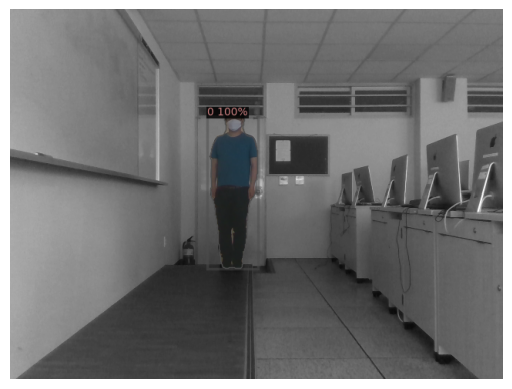

In [4]:
mask_rcnn_outputs = mask_rcnn_predictor(im)
v = Visualizer(im, None, scale=1.0, instance_mode=ColorMode.IMAGE_BW)
v = v.draw_instance_predictions(mask_rcnn_outputs["instances"].to("cpu"))
plt.imshow(v.get_image())
plt.axis('off')

# 5. 관절 검출 모델 로드

In [14]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.DEVICE='cpu' #만약 gpu를 사용한다면 ‘cuda’로 수정
predictor = DefaultPredictor(cfg)

model_final_a6e10b.pkl: 237MB [06:20, 623kB/s]                                                                         


# 6. Detectron2를 통한 신체 관절 검출 및 출력

C:\Users\user\anaconda3\envs\detectron\lib\site-packages\detectron2\structures\keypoints.py:224: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  y_int = (pos - x_int) // w


(-0.5, 639.5, 479.5, -0.5)

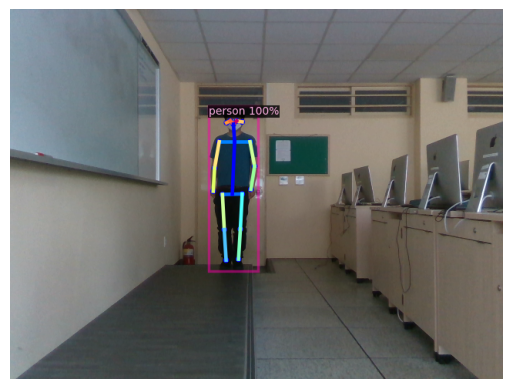

In [15]:
outputs = predictor(im)
keypoints=outputs['instances'].get_fields()['pred_keypoints'].to('cpu').numpy()
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')

# 7. 어깨 및 발끝 관절 검출 시각화

(-0.5, 639.5, 479.5, -0.5)

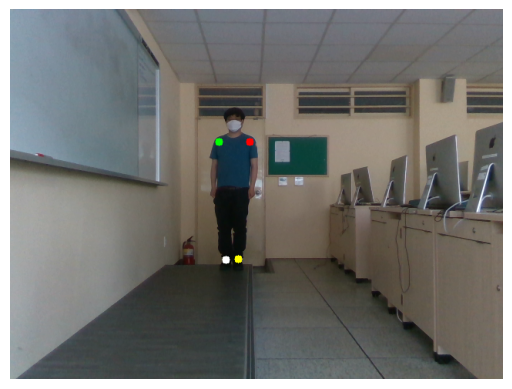

In [16]:
pt1=tuple(keypoints[0,5,:2].astype(int)) #왼쪽 어께
pt2=tuple(keypoints[0,6,:2].astype(int)) #오른쪽 어께
pt3=tuple(keypoints[0,15,:2].astype(int)) #왼쪽 발끝
pt4=tuple(keypoints[0,16,:2].astype(int)) #오른쪽 발끝
#관절 시각화
s_img=im.copy()
cv2.circle(s_img,pt1,5,(255,0,0),-1)
cv2.circle(s_img,pt2,5,(0,255,0),-1)
cv2.circle(s_img,pt3,5,(255,255,0),-1)
cv2.circle(s_img,pt4,5,(255,255,255),-1)
plt.imshow(s_img)
plt.axis('off')

# 8. 신체 중심선 검출

(-0.5, 639.5, 479.5, -0.5)

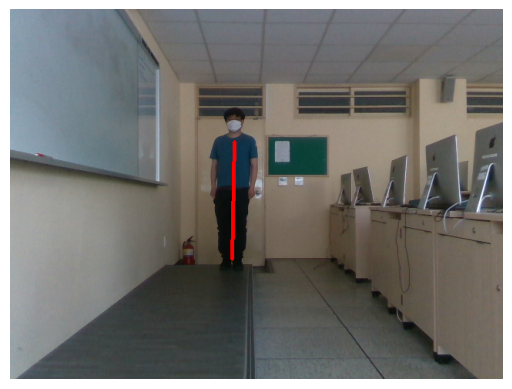

In [17]:
#어깨의 중앙 계산
s_center=(keypoints[0,5,:2].astype(int)+keypoints[0,6,:2].astype(int))//2
#발의 중앙 계산
f_center=(keypoints[0,15,:2].astype(int)+keypoints[0,16,:2].astype(int))//2
#몸의 중심선 출력
s_img=im.copy()
cv2.line(s_img,tuple(s_center),tuple(f_center),(255,0,0),3)
plt.imshow(s_img)
plt.axis('off')

# 9. 동영상 파일에서 쓰러짐 검출 
####   – 결과파일은 result.mp4에 저장되어 이를 재생하면 쓰러짐이 발생한 곳에 Fall Detection 글자가 띄어진다.

In [ ]:
prev=None #이전 각도 저장
continus_frame=0 #연속된 최근 쓰러짐 프레임수 저장
T_a=0.03 #기준 각도
T_f=5 #기준 프레임
isFall=False #쓰러짐 여부 
video=cv2.VideoCapture('fall_test.mp4') #쓰러짐 발생 여부를 확인할 파일명
assert video.isOpened() #파일 존재 여부 확인
width = video.get(cv2.CAP_PROP_FRAME_WIDTH) #재생할 파일의 넓이 얻기
height = video.get(cv2.CAP_PROP_FRAME_HEIGHT) #재생할 파일의 높이 얻기
fps = video.get(cv2.CAP_PROP_FPS) #재생할 파일의 프레임 레이트 (초당 프레임)
fourcc = cv2.VideoWriter_fourcc(*'DIVX') #저장할 비디오 코덱
filename = 'result.mp4' #저장할 파일 이름
out = cv2.VideoWriter(filename, fourcc, fps, (int(width), int(height))) #저장할 비디오 스트림 생성
while True: #무한루프
  ret, frame=video.read()
  if(not ret):  break #더이상 읽을 프레임이 없으면 ret는 null임
  outputs = predictor(frame) #각 프레임에서 detectron2를 통한 관절 검출
  keypoints=outputs['instances'].get_fields()['pred_keypoints'].to('cpu').numpy()
  #신체 중심선 검출
  s_center=(keypoints[0,5,:2].astype(int)+keypoints[0,6,:2].astype(int))//2  #어께
  f_center=(keypoints[0,15,:2].astype(int)+keypoints[0,16,:2].astype(int))//2 #발
  #지면과 이루는 각도 계산
  diff=s_center-f_center
  theta=np.arctan(diff[1]/diff[0])
  #각도 변화를 체크
  if(prev==None):
    prev=theta
  if(abs(theta)>abs(prev)):
    prev=theta
  diff_a=theta-prev
  prev=theta
  if(abs(diff_a)>T_a):
    continus_frame+=1
  else:
    continus_frame=0
  if(continus_frame>=T_f):
    print('fall detection')
    isFall=True
  if(isFall):
    cv2.putText(frame,"Fall Detection", (20,100),cv2.FONT_HERSHEY_SIMPLEX,3,(0,0,255),4)
  out.write(frame)
video.release()
out.release()